# Data Loading and Overview

## Import

In [93]:
import numpy as np
import pandas as pd

from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error

## Load data

In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
display(sample_submission.head())

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [3]:
train_df = pd.read_csv('train.csv')
submission_df = pd.read_csv('test.csv')

print(train_df.shape)
print(submission_df.shape)

(1460, 81)
(1459, 80)


## Train-test split

In [4]:
y = train_df['SalePrice']
X = train_df.drop(['SalePrice', 'Id'], axis=1)

submission_ids = submission_df['Id']
submission_df = submission_df.drop(['Id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1095, 79)
(365, 79)


## Data overview

In [5]:
# display(X_train.head())
display(X_train.info())
# display(X_train.describe())
# display(X_train.describe(include='O'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1023 to 1126
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1095 non-null   int64  
 1   MSZoning       1095 non-null   object 
 2   LotFrontage    895 non-null    float64
 3   LotArea        1095 non-null   int64  
 4   Street         1095 non-null   object 
 5   Alley          70 non-null     object 
 6   LotShape       1095 non-null   object 
 7   LandContour    1095 non-null   object 
 8   Utilities      1095 non-null   object 
 9   LotConfig      1095 non-null   object 
 10  LandSlope      1095 non-null   object 
 11  Neighborhood   1095 non-null   object 
 12  Condition1     1095 non-null   object 
 13  Condition2     1095 non-null   object 
 14  BldgType       1095 non-null   object 
 15  HouseStyle     1095 non-null   object 
 16  OverallQual    1095 non-null   int64  
 17  OverallCond    1095 non-null   int64  
 18  YearB

None

### Target Variable

In [6]:
y_train.describe()

count      1095.000000
mean     181712.286758
std       77955.082565
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      215000.000000
max      745000.000000
Name: SalePrice, dtype: float64

mu = 181712.29
sigma = 77919.48


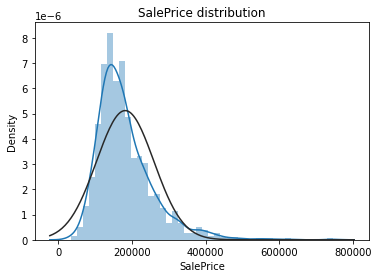

In [7]:
sns.distplot(y_train, fit=norm);

# fitted mean and variance
(mu, sigma) = norm.fit(y_train)
print('mu = {:.2f}'.format(mu))
print('sigma = {:.2f}'.format(sigma))

# normal distribution with fitted parameters
plt.title('SalePrice distribution')
plt.show()

Notes about target variable:

1. Deviation from the normal distribution.

2. Considerable positive skewness.

As linear models deals well with normally distributed data, let's transform target variable


### Log-transformation

mu = 12.03
sigma = 0.39


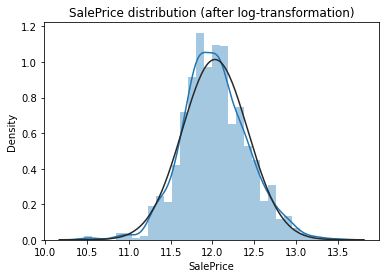

In [8]:
y_train, y_test = np.log1p(y_train), np.log1p(y_test)

# new distribution 
sns.distplot(y_train , fit=norm);

# fitted mean and variance
(mu, sigma) = norm.fit(y_train)
print('mu = {:.2f}'.format(mu))
print('sigma = {:.2f}'.format(sigma))

# normal distribution with fitted parameters
plt.title('SalePrice distribution (after log-transformation)')
plt.show()

Ok, now it looks much better.

# Preprocessing

## Split features by data type

In [9]:
train_numeric_df = X_train.select_dtypes(include=['int', 'float'])
train_object_df = X_train.select_dtypes(include='object')

# separate date features
date_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
train_date_df = X_train[date_cols]
train_numeric_df.drop(date_cols, axis=1, inplace=True)

print(train_numeric_df.shape)
print(train_object_df.shape)
print(train_date_df.shape)
print(X_train.shape)

(1095, 31)
(1095, 43)
(1095, 5)
(1095, 79)


## Features Analysis

### Object features

In [10]:
print('Object features')
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')

for column in train_object_df.columns:
    print(column)
    print('-------------------------------')
    # sns.countplot(x=column, data=train_object_df)
    # plt.show()
    display(train_object_df[column].value_counts(normalize=False, dropna=False))
    print('===============================')

Object features
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
MSZoning
-------------------------------


RL         866
RM         164
FV          47
RH          14
C (all)      4
Name: MSZoning, dtype: int64

Street
-------------------------------


Pave    1091
Grvl       4
Name: Street, dtype: int64

Alley
-------------------------------


NaN     1025
Grvl      44
Pave      26
Name: Alley, dtype: int64

LotShape
-------------------------------


Reg    681
IR1    371
IR2     35
IR3      8
Name: LotShape, dtype: int64

LandContour
-------------------------------


Lvl    992
Bnk     45
HLS     32
Low     26
Name: LandContour, dtype: int64

Utilities
-------------------------------


AllPub    1094
NoSeWa       1
Name: Utilities, dtype: int64

LotConfig
-------------------------------


Inside     766
Corner     209
CulDSac     80
FR2         37
FR3          3
Name: LotConfig, dtype: int64

LandSlope
-------------------------------


Gtl    1036
Mod      50
Sev       9
Name: LandSlope, dtype: int64

Neighborhood
-------------------------------


NAmes      167
CollgCr    112
OldTown     87
Edwards     83
Somerst     62
NWAmes      60
Gilbert     59
NridgHt     58
Sawyer      51
BrkSide     44
SawyerW     40
Crawfor     39
Mitchel     38
NoRidge     31
Timber      27
IDOTRR      25
StoneBr     20
ClearCr     19
SWISU       18
Blmngtn     15
BrDale      13
MeadowV     10
Veenker      9
NPkVill      7
Blueste      1
Name: Neighborhood, dtype: int64

Condition1
-------------------------------


Norm      946
Feedr      59
Artery     37
RRAn       17
PosN       14
RRAe       10
PosA        6
RRNn        5
RRNe        1
Name: Condition1, dtype: int64

Condition2
-------------------------------


Norm      1086
Feedr        3
Artery       2
PosN         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

BldgType
-------------------------------


1Fam      915
TwnhsE     84
Duplex     37
Twnhs      32
2fmCon     27
Name: BldgType, dtype: int64

HouseStyle
-------------------------------


1Story    541
2Story    339
1.5Fin    114
SLvl       50
SFoyer     23
1.5Unf     11
2.5Unf     10
2.5Fin      7
Name: HouseStyle, dtype: int64

RoofStyle
-------------------------------


Gable      843
Hip        225
Flat        11
Gambrel      9
Mansard      5
Shed         2
Name: RoofStyle, dtype: int64

RoofMatl
-------------------------------


CompShg    1076
Tar&Grv       9
WdShngl       4
WdShake       3
Roll          1
ClyTile       1
Metal         1
Name: RoofMatl, dtype: int64

Exterior1st
-------------------------------


VinylSd    394
HdBoard    167
MetalSd    160
Wd Sdng    159
Plywood     75
CemntBd     42
BrkFace     38
Stucco      19
WdShing     19
AsbShng     16
BrkComm      2
AsphShn      1
Stone        1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

Exterior2nd
-------------------------------


VinylSd    385
Wd Sdng    154
HdBoard    154
MetalSd    153
Plywood    103
CmentBd     41
Wd Shng     32
Stucco      21
AsbShng     17
BrkFace     15
ImStucc      6
Brk Cmn      6
AsphShn      3
Stone        3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

MasVnrType
-------------------------------


None       635
BrkFace    345
Stone       99
BrkCmn      12
NaN          4
Name: MasVnrType, dtype: int64

ExterQual
-------------------------------


TA    682
Gd    363
Ex     39
Fa     11
Name: ExterQual, dtype: int64

ExterCond
-------------------------------


TA    960
Gd    108
Fa     24
Ex      2
Po      1
Name: ExterCond, dtype: int64

Foundation
-------------------------------


PConc     492
CBlock    468
BrkTil    108
Slab       19
Stone       5
Wood        3
Name: Foundation, dtype: int64

BsmtQual
-------------------------------


TA     485
Gd     461
Ex      94
Fa      28
NaN     27
Name: BsmtQual, dtype: int64

BsmtCond
-------------------------------


TA     977
Gd      52
Fa      38
NaN     27
Po       1
Name: BsmtCond, dtype: int64

BsmtExposure
-------------------------------


No     719
Av     163
Gd      98
Mn      88
NaN     27
Name: BsmtExposure, dtype: int64

BsmtFinType1
-------------------------------


Unf    315
GLQ    313
ALQ    170
BLQ    112
Rec    101
LwQ     57
NaN     27
Name: BsmtFinType1, dtype: int64

BsmtFinType2
-------------------------------


Unf    946
Rec     42
LwQ     33
NaN     27
BLQ     20
ALQ     17
GLQ     10
Name: BsmtFinType2, dtype: int64

Heating
-------------------------------


GasA     1070
GasW       15
Grav        4
Wall        3
OthW        2
Floor       1
Name: Heating, dtype: int64

HeatingQC
-------------------------------


Ex    555
TA    319
Gd    181
Fa     39
Po      1
Name: HeatingQC, dtype: int64

CentralAir
-------------------------------


Y    1017
N      78
Name: CentralAir, dtype: int64

Electrical
-------------------------------


SBrkr    1002
FuseA      66
FuseF      23
FuseP       3
NaN         1
Name: Electrical, dtype: int64

KitchenQual
-------------------------------


TA    550
Gd    440
Ex     73
Fa     32
Name: KitchenQual, dtype: int64

Functional
-------------------------------


Typ     1013
Min2      28
Min1      27
Mod       13
Maj1       9
Maj2       4
Sev        1
Name: Functional, dtype: int64

FireplaceQu
-------------------------------


NaN    512
Gd     286
TA     236
Fa      26
Ex      19
Po      16
Name: FireplaceQu, dtype: int64

GarageType
-------------------------------


Attchd     651
Detchd     289
BuiltIn     69
NaN         58
Basment     15
CarPort      7
2Types       6
Name: GarageType, dtype: int64

GarageFinish
-------------------------------


Unf    449
RFn    321
Fin    267
NaN     58
Name: GarageFinish, dtype: int64

GarageQual
-------------------------------


TA     986
NaN     58
Fa      35
Gd      12
Ex       3
Po       1
Name: GarageQual, dtype: int64

GarageCond
-------------------------------


TA     995
NaN     58
Fa      27
Gd       9
Po       4
Ex       2
Name: GarageCond, dtype: int64

PavedDrive
-------------------------------


Y    1004
N      67
P      24
Name: PavedDrive, dtype: int64

PoolQC
-------------------------------


NaN    1089
Gd        2
Ex        2
Fa        2
Name: PoolQC, dtype: int64

Fence
-------------------------------


NaN      877
MnPrv    119
GdPrv     47
GdWo      43
MnWw       9
Name: Fence, dtype: int64

MiscFeature
-------------------------------


NaN     1052
Shed      40
Gar2       1
Othr       1
TenC       1
Name: MiscFeature, dtype: int64

SaleType
-------------------------------


WD       955
New       89
COD       30
ConLD      7
ConLw      4
CWD        4
ConLI      3
Con        2
Oth        1
Name: SaleType, dtype: int64

SaleCondition
-------------------------------


Normal     908
Partial     90
Abnorml     71
Family      17
Alloca       5
AdjLand      4
Name: SaleCondition, dtype: int64

#### Drop (low variance):

'Street', 'Alley', 'LandContour', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'Heating', 'Electrical', 'SaleType', 'SaleCondition', 'Utilities', 'BsmtCond', 'BsmtFinType2', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'CentralAir', 'PoolQC', 'MiscFeature'

#### Fill NaN with 'None':

'GarageFinish', 'FireplaceQu', 'BsmtFinType1', 'BsmtExposure', 'BsmtQual', 'GarageType'

#### Combine 'Gd' + 'Ex' into 'Gd':

'ExterQual', 'ExterCond', 'BsmtQual', 'KitchenQual', 'FireplaceQu'

#### Combine uncommon values into 'Other':

'MSZoning': if not in ('RL', 'RM', 'FV') then 'Other'

'LotShape': if not in ('Reg', 'IR1') then 'Other'

'LotConfig': if not in ('Inside', 'Corner', 'CulDSac') then 'Other'

'Neighborhood': if not in ('NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NWAmes', 'Gilbert', 'NridgHt', 'Sawyer', 'BrkSide', 'SawyerW', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber', 'IDOTRR') then 'Other'

'HouseStyle': if not in ('1Story', '2Story', '1.5Fin', 'SLvl') then 'Other'

'RoofStyle': if not in ('Gable', 'Hip') then 'Other'

'Exterior1st': if not in ('VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood', 'CemntBd', 'BrkFace', 'Stucco', 'WdShing', 'AsbShng') then 'Other'

'Exterior2nd': if not in ('VinylSd', 'Wd Sdng', 'HdBoard', 'MetalSd', 'Plywood', 'CemntBd', 'Wd Shng', 'Stucco', 'AsbShng', 'BrkFace') then 'Other'

'MasVnrType': if not in ('None', 'BrkFace', 'Stone') then 'Other'

'Foundation': if not in ('PConc', 'CBlock', 'BrkTil') then 'Other'

'GarageType': if not in ('Attchd', 'Detchd', 'BuiltIn', 'None') then 'Other'

'ExterQual': if not in ('TA', 'Gd') then 'Other'

'ExterCond': if not in ('TA', 'Gd') then 'Other'

'BsmtQual': if not in ('TA', 'Gd', 'None') then 'Other'

'HeatingQC': if not in ('Ex', 'Gd', 'TA') then 'Other'

'KitchenQual': if not in ('TA', 'Gd') then 'Other'

'FireplaceQu': if not in ('TA', 'Gd', 'None') then 'Other'

#### Other approaches:

'BldgType': leave as it is | or drop (low variance)

'Fence': binarize (NaN - 0, others - 1)

In [11]:
# dataframes for which abovementioned operations would be applied on
dfs = [train_object_df, X_train, X_test, submission_df]

In [12]:
# drop
features_to_drop = ['Street', 'Alley', 'LandContour', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'Heating', 'Electrical', 'SaleType', 'SaleCondition', 
                    'Utilities', 'BsmtCond', 'BsmtFinType2', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'CentralAir', 'PoolQC', 'MiscFeature']

for df in dfs:
    df.drop(features_to_drop, axis=1, inplace=True)

In [13]:
# fill NaN with 'None'
features_with_nan = ['GarageFinish', 'FireplaceQu', 'BsmtFinType1', 'BsmtExposure', 'BsmtQual', 'GarageType']

for df in dfs:
    for column in features_with_nan:
        df[column].fillna(value='None', inplace=True)

In [14]:
# fill nulls in submission dataframe according to non-null values distribution
for column in submission_df.columns:
    value_distr = X_train[column].value_counts(normalize=True)
    nans = submission_df[column].isnull()
    submission_df.loc[nans, column] = np.random.choice(value_distr.index, size=len(submission_df[nans]), p=value_distr.values)

In [15]:
# replace values
features_to_replace = ['ExterQual', 'ExterCond', 'BsmtQual', 'KitchenQual', 'FireplaceQu']

for df in dfs:
    for column in features_to_replace:
        df.loc[df[column]=='Ex', column] = 'Gd'

In [16]:
# combine values
tuple_1 = ('MSZoning', ['RL', 'RM', 'FV'])
tuple_2 = ('LotShape', ['Reg', 'IR1'])
tuple_3 = ('LotConfig', ['Inside', 'Corner', 'CulDSac'])
tuple_4 = ('Neighborhood', ['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NWAmes', 'Gilbert', 'NridgHt', 'Sawyer', 
                            'BrkSide', 'SawyerW', 'Crawfor', 'Mitchel', 'NoRidge', 'Timber', 'IDOTRR'])
tuple_5 = ('HouseStyle', ['1Story', '2Story', '1.5Fin', 'SLvl'])
tuple_6 = ('RoofStyle', ['Gable', 'Hip'])
tuple_7 =  ('Exterior1st', ['VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', 'Plywood', 'CemntBd', 'BrkFace', 'Stucco', 'WdShing', 'AsbShng'])
tuple_8 =  ('Exterior2nd', ['VinylSd', 'Wd Sdng', 'HdBoard', 'MetalSd', 'Plywood', 'CemntBd', 'Wd Shng', 'Stucco', 'AsbShng', 'BrkFace'])
tuple_9 =  ('MasVnrType', ['None', 'BrkFace', 'Stone'])
tuple_10 = ('Foundation', ['PConc', 'CBlock', 'BrkTil'])
tuple_11 = ('GarageType', ['Attchd', 'Detchd', 'BuiltIn', 'None'])
tuple_12 = ('ExterQual', ['TA', 'Gd'])
tuple_13 = ('ExterCond', ['TA', 'Gd'])
tuple_14 = ('KitchenQual', ['TA', 'Gd'])
tuple_15 = ('BsmtQual', ['TA', 'Gd', 'None'])
tuple_16 = ('FireplaceQu', ['TA', 'Gd', 'None'])
tuple_17 = ('HeatingQC', ['Ex', 'Gd', 'TA'])

tuples_list = [tuple_1, tuple_2, tuple_3, tuple_4, tuple_5, tuple_6, tuple_7, tuple_8, tuple_9, tuple_10, tuple_11, 
               tuple_12, tuple_13, tuple_14, tuple_15, tuple_16, tuple_17]

for df in dfs:
    for item in tuples_list:
        df.loc[-df[item[0]].isin(item[1]), item[0]] = 'Other'


In [17]:
# binarize
for df in dfs:
    df['Fence_enc'] = 0
    df.loc[df['Fence'].notnull(), 'Fence_enc'] = 1
    df.drop(['Fence'], axis=1, inplace=True)

In [18]:
print(train_object_df.shape)

(1095, 22)


### Numeric features

In [19]:
print(train_numeric_df.columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object')


In [20]:
# separate in fact categorical features from numeric ones
categorical_features = ['MSSubClass', 'OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']

train_categorical_df = train_numeric_df[categorical_features]
train_numeric_df.drop(categorical_features, axis=1, inplace=True)

In [21]:
print('Categorical features')
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')

for column in train_categorical_df.columns:
    print(column)
    print('-------------------------------')
    # sns.countplot(x=column, data=train_categorical_df)
    # plt.show()
    display(train_categorical_df[column].value_counts(normalize=False, dropna=False))
    print('===============================')

Categorical features
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
MSSubClass
-------------------------------


20     404
60     225
50     106
120     63
70      52
30      47
160     46
80      43
90      37
190     26
75      14
85      14
45       9
180      7
40       2
Name: MSSubClass, dtype: int64

OverallQual
-------------------------------


6     292
5     283
7     244
8     130
4      83
9      34
3      15
10     11
1       2
2       1
Name: OverallQual, dtype: int64

OverallCond
-------------------------------


5    619
6    191
7    155
8     49
4     41
3     18
9     17
2      4
1      1
Name: OverallCond, dtype: int64

BsmtFullBath
-------------------------------


0    646
1    438
2     10
3      1
Name: BsmtFullBath, dtype: int64

BsmtHalfBath
-------------------------------


0    1033
1      61
2       1
Name: BsmtHalfBath, dtype: int64

FullBath
-------------------------------


2    585
1    481
3     26
0      3
Name: FullBath, dtype: int64

HalfBath
-------------------------------


0    684
1    405
2      6
Name: HalfBath, dtype: int64

BedroomAbvGr
-------------------------------


3    604
2    259
4    175
1     34
5     14
6      5
0      3
8      1
Name: BedroomAbvGr, dtype: int64

KitchenAbvGr
-------------------------------


1    1045
2      48
0       1
3       1
Name: KitchenAbvGr, dtype: int64

TotRmsAbvGrd
-------------------------------


6     306
7     250
5     197
8     142
4      68
9      61
10     35
11     15
3      11
12      8
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

Fireplaces
-------------------------------


0    512
1    491
2     89
3      3
Name: Fireplaces, dtype: int64

GarageCars
-------------------------------


2    635
1    262
3    138
0     58
4      2
Name: GarageCars, dtype: int64

#### Drop:

'MSSubClass', 'BsmtHalfBath', 'KitchenAbvGr'

In [22]:
# drop
features_to_drop = ['MSSubClass', 'BsmtHalfBath', 'KitchenAbvGr']

train_categorical_df.drop(features_to_drop, axis=1, inplace=True)
X_train.drop(features_to_drop, axis=1, inplace=True)
X_test.drop(features_to_drop, axis=1, inplace=True)
submission_df.drop(features_to_drop, axis=1, inplace=True)

In [23]:
print('Numerical features')
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')

for column in train_numeric_df.columns:
    print(column)
    print('-------------------------------')
    display(train_numeric_df[column].value_counts(normalize=False, dropna=False))
    print('===============================')

Numerical features
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
LotFrontage
-------------------------------


NaN      200
60.0     105
70.0      54
80.0      51
50.0      46
        ... 
174.0      1
149.0      1
112.0      1
124.0      1
144.0      1
Name: LotFrontage, Length: 106, dtype: int64

LotArea
-------------------------------


9600     21
7200     15
6000     14
10800    13
9000     10
         ..
9464      1
23257     1
10970     1
8924      1
8190      1
Name: LotArea, Length: 845, dtype: int64

MasVnrArea
-------------------------------


0.0      632
180.0      7
108.0      7
16.0       6
120.0      6
        ... 
88.0       1
126.0      1
366.0      1
234.0      1
415.0      1
Name: MasVnrArea, Length: 279, dtype: int64

BsmtFinSF1
-------------------------------


0       342
24       11
16        8
20        5
936       5
       ... 
642       1
639       1
270       1
273       1
2096      1
Name: BsmtFinSF1, Length: 531, dtype: int64

BsmtFinSF2
-------------------------------


0       973
180       5
374       3
41        2
551       2
       ... 
202       1
193       1
184       1
181       1
1127      1
Name: BsmtFinSF2, Length: 109, dtype: int64

BsmtUnfSF
-------------------------------


0       84
728      7
384      6
572      6
672      6
        ..
483      1
482      1
479      1
476      1
2046     1
Name: BsmtUnfSF, Length: 655, dtype: int64

TotalBsmtSF
-------------------------------


0       27
864     23
672     15
912     14
1040    10
        ..
1153     1
714      1
1151     1
1149     1
2046     1
Name: TotalBsmtSF, Length: 603, dtype: int64

1stFlrSF
-------------------------------


864     18
912     13
1040    11
672      9
848      8
        ..
1038     1
1035     1
1034     1
1029     1
2046     1
Name: 1stFlrSF, Length: 631, dtype: int64

2ndFlrSF
-------------------------------


0       613
504       8
546       7
720       7
672       6
       ... 
713       1
714       1
716       1
725       1
1818      1
Name: 2ndFlrSF, Length: 345, dtype: int64

LowQualFinSF
-------------------------------


0      1075
80        3
392       1
528       1
515       1
513       1
481       1
473       1
420       1
397       1
390       1
53        1
384       1
360       1
234       1
205       1
144       1
120       1
572       1
Name: LowQualFinSF, dtype: int64

GrLivArea
-------------------------------


864     15
1040    10
1200     8
912      8
1092     7
        ..
1103     1
1108     1
1109     1
1110     1
2046     1
Name: GrLivArea, Length: 707, dtype: int64

GarageArea
-------------------------------


0       58
440     37
576     35
528     26
240     25
        ..
590      1
592      1
594      1
595      1
1418     1
Name: GarageArea, Length: 383, dtype: int64

WoodDeckSF
-------------------------------


0      579
192     27
144     27
100     23
120     21
      ... 
206      1
207      1
35       1
209      1
857      1
Name: WoodDeckSF, Length: 239, dtype: int64

OpenPorchSF
-------------------------------


0      480
36      23
20      17
40      14
45      14
      ... 
91       1
53       1
4        1
117      1
547      1
Name: OpenPorchSF, Length: 184, dtype: int64

EnclosedPorch
-------------------------------


0      949
112     12
96       5
216      4
144      4
      ... 
136      1
134      1
129      1
128      1
552      1
Name: EnclosedPorch, Length: 94, dtype: int64

3SsnPorch
-------------------------------


0      1076
144       2
168       2
180       2
216       2
130       1
140       1
153       1
182       1
196       1
245       1
290       1
304       1
320       1
407       1
508       1
Name: 3SsnPorch, dtype: int64

ScreenPorch
-------------------------------


0      1001
192       6
120       4
180       4
224       4
       ... 
175       1
40        1
182       1
184       1
480       1
Name: ScreenPorch, Length: 64, dtype: int64

PoolArea
-------------------------------


0      1089
480       1
512       1
519       1
555       1
648       1
738       1
Name: PoolArea, dtype: int64

MiscVal
-------------------------------


0       1052
500        8
400        8
700        5
2000       4
450        4
480        2
1200       2
2500       1
600        1
8300       1
350        1
800        1
1150       1
1300       1
1400       1
3500       1
620        1
Name: MiscVal, dtype: int64

#### Drop:

'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'

In [24]:
# drop
features_to_drop = ['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

train_numeric_df.drop(features_to_drop, axis=1, inplace=True)
X_train.drop(features_to_drop, axis=1, inplace=True)
X_test.drop(features_to_drop, axis=1, inplace=True)
submission_df.drop(features_to_drop, axis=1, inplace=True)

In [25]:
print('Date features')
print('-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-')

for column in train_date_df.columns:
    print(column)
    print('-------------------------------')
    display(train_date_df[column].value_counts(normalize=False, dropna=False))
    print('===============================')

Date features
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
YearBuilt
-------------------------------


2005    50
2006    48
2004    45
2007    35
2003    34
        ..
1905     1
1904     1
1898     1
1882     1
2010     1
Name: YearBuilt, Length: 109, dtype: int64

YearRemodAdd
-------------------------------


1950    135
2006     72
2005     59
2007     54
2004     47
       ... 
1952      4
2010      4
1986      3
1982      3
1951      3
Name: YearRemodAdd, Length: 61, dtype: int64

GarageYrBlt
-------------------------------


NaN       58
2005.0    50
2004.0    44
2006.0    41
2003.0    38
          ..
1900.0     1
1908.0     1
1922.0     1
1928.0     1
1906.0     1
Name: GarageYrBlt, Length: 95, dtype: int64

MoSold
-------------------------------


6     191
7     177
5     166
4     100
8      84
3      82
10     67
11     64
9      47
12     44
1      38
2      35
Name: MoSold, dtype: int64

YrSold
-------------------------------


2009    258
2007    245
2006    235
2008    228
2010    129
Name: YrSold, dtype: int64

'GarageYrBlt': drop

'YearRemodAdd': drop (further consideration)

'YrSold' - 'YearBuilt' = 'Age'

'MoSold': encode with get_dummies as object variable

In [26]:
dfs = [train_date_df, X_train, X_test, submission_df]
for df in dfs:
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [27]:
display(train_date_df['Age'].value_counts(normalize=False, dropna=False))

1      74
0      47
2      31
3      29
4      26
       ..
107     1
104     1
103     1
102     1
136     1
Name: Age, Length: 118, dtype: int64

In [28]:
print(X_train.shape)
print(X_test.shape)
print(submission_df.shape)

(1095, 45)
(365, 45)
(1459, 45)


## Missing Values

In [29]:
for column in X_train.columns:
    nulls_pct = float(X_train[column].isnull().sum()/len(X_train[column]))
    if nulls_pct > 0:
        print(column+': '+str(nulls_pct))


LotFrontage: 0.182648401826484
MasVnrArea: 0.0036529680365296802


In [30]:
columns = ['LotFrontage', 'MasVnrArea']
for column in columns:
    print(column)
    print('-------------------------------')
    display(X_train[column].value_counts(normalize=False, dropna=False))
    print('===============================')

LotFrontage
-------------------------------


NaN      200
60.0     105
70.0      54
80.0      51
50.0      46
        ... 
174.0      1
149.0      1
112.0      1
124.0      1
144.0      1
Name: LotFrontage, Length: 106, dtype: int64

MasVnrArea
-------------------------------


0.0      632
180.0      7
108.0      7
16.0       6
120.0      6
        ... 
88.0       1
126.0      1
366.0      1
234.0      1
415.0      1
Name: MasVnrArea, Length: 279, dtype: int64

'LotFrontage': drop

'MasVnrArea': replace NaN values by 0

In [31]:
dfs = [train_numeric_df, X_train, X_test, submission_df]
for df in dfs:
    df.drop(['LotFrontage'], axis=1, inplace=True)
    df['MasVnrArea'].fillna(value=0, inplace=True)

## Outliers

In [32]:
for column in train_numeric_df.columns:
    # Find the mean and standard dev
    std = train_numeric_df[column].std()
    mean = train_numeric_df[column].mean()

    # Calculate the cutoff
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off

    # Trim the outliers
    train_numeric_df = train_numeric_df[(train_numeric_df[column] < upper) & (train_numeric_df[column] > lower)]
    X_train = X_train[(X_train[column] < upper) & (X_train[column] > lower)]


In [33]:
y_train = y_train[train_numeric_df.index]

In [34]:
print(X_train.shape)

(1003, 44)


## Encoding, Correlations, and Scaling

### Preparation

In [35]:
# auxiliary dataframe to calculate correlation
X_for_corr = X_train.copy()

print(X_train.shape)
print(X_for_corr.shape)

(1003, 44)
(1003, 44)


In [36]:
train_numeric_df = X_train.select_dtypes(include=['int', 'float'])
train_object_df = X_train.select_dtypes(include='object')

print(train_numeric_df.shape)
print(train_object_df.shape)

(1003, 23)
(1003, 21)


'MoSold': leave as it is for correlation and encode with get_dummies for modeling

Other 'train_numeric_df' features: leave as it is

'train_object_df' features: encode with LabelEncoder for correlations and with get_dummies for modeling

In [37]:
enc = LabelEncoder()

to_encode = list(train_object_df.columns)
for column in to_encode:
    X_for_corr[column+'_enc'] = enc.fit_transform(X_for_corr[column])

X_for_corr.drop(to_encode, axis=1, inplace=True)

### Correlations

In [38]:
corr_matrix = X_for_corr.corr()
corr_features = []
for column in corr_matrix.columns:
    for row in corr_matrix.columns:
        if column == row:
            pass
        elif corr_matrix.loc[row, column] >= 0.7:
            if column not in corr_features:
                corr_features.append(column)
        else:
            pass
        
corr_features

['TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'Exterior1st_enc',
 'Exterior2nd_enc']

In [39]:
corr_matrix_strong = corr_matrix.loc[corr_features, corr_features]
corr_matrix_strong

,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageCars,GarageArea,Exterior1st_enc,Exterior2nd_enc
TotalBsmtSF,1.000000,0.763996,-0.278431,0.306209,0.180843,0.429314,0.448749,0.048606,0.054685
1stFlrSF,0.763996,1.000000,-0.336066,0.431178,0.317847,0.407574,0.431981,0.010545,0.040681
2ndFlrSF,-0.278431,-0.336066,1.000000,0.700129,0.603761,0.166623,0.124477,0.095602,0.085376
GrLivArea,0.306209,0.431178,0.700129,1.000000,0.821318,0.460249,0.440422,0.098992,0.110719
TotRmsAbvGrd,0.180843,0.317847,0.603761,0.821318,1.000000,0.333119,0.304002,0.089666,0.097347
GarageCars,0.429314,0.407574,0.166623,0.460249,0.333119,1.000000,0.883419,0.104258,0.106264
GarageArea,0.448749,0.431981,0.124477,0.440422,0.304002,0.883419,1.000000,0.073775,0.069945
Exterior1st_enc,0.048606,0.010545,0.095602,0.098992,0.089666,0.104258,0.073775,1.000000,0.852518
Exterior2nd_enc,0.054685,0.040681,0.085376,0.110719,0.097347,0.106264,0.069945,0.852518,1.000000


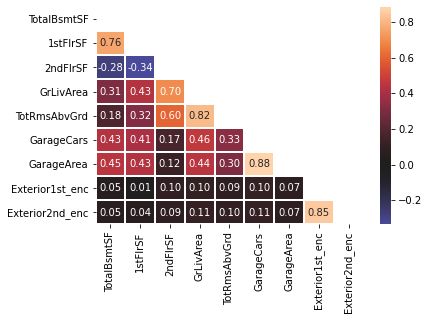

In [40]:
# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr_matrix_strong, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr_matrix_strong, mask=mask, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

#### Drop:

'GarageArea', 'GrLivArea', 'TotalBsmtSF', 'Exterior2nd'

In [41]:
to_drop = ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'Exterior2nd']
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)
submission_df.drop(to_drop, axis=1, inplace=True)

### Categorical features encoding

In [42]:
to_encode.remove('Exterior2nd')
to_encode.append('MoSold')
X_train = pd.get_dummies(X_train, columns=to_encode)
X_test = pd.get_dummies(X_test, columns=to_encode)
submission_df = pd.get_dummies(submission_df, columns=to_encode)

In [43]:
print(X_train.shape)
print(X_test.shape)
print(submission_df.shape)

(1003, 133)
(365, 133)
(1459, 133)


### Numeric features scaling

In [50]:
features_to_scale = list(train_numeric_df.columns)
for item in ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'MoSold']:
    features_to_scale.remove(item)

features_to_scale

['LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'Fence_enc',
 'Age']

In [51]:
print('Average')
print('----------------------')
print(X_train[features_to_scale].mean())
print('======================')
print('Standard Deviation')
print('----------------------')
print(X_train[features_to_scale].std())

Average
----------------------
LotArea         9483.278166
OverallQual        6.031904
OverallCond        5.577268
MasVnrArea        85.444666
BsmtFinSF1       421.409771
BsmtUnfSF        552.935194
1stFlrSF        1125.244267
2ndFlrSF         335.046859
BsmtFullBath       0.403789
FullBath           1.550349
HalfBath           0.368893
BedroomAbvGr       2.865404
TotRmsAbvGrd       6.417747
Fireplaces         0.572283
GarageCars         1.736790
WoodDeckSF        84.233300
OpenPorchSF       41.952144
Fence_enc          0.202393
Age               37.024925
dtype: float64
Standard Deviation
----------------------
LotArea         3759.700671
OverallQual        1.292918
OverallCond        1.104681
MasVnrArea       134.204463
BsmtFinSF1       404.733244
BsmtUnfSF        424.829270
1stFlrSF         329.915427
2ndFlrSF         416.009067
BsmtFullBath       0.506904
FullBath           0.530702
HalfBath           0.494994
BedroomAbvGr       0.774358
TotRmsAbvGrd       1.503809
Fireplaces      

In [52]:
scaler = StandardScaler()

for column in features_to_scale:
    scaler.fit(X_train[[column]])
    X_train[column] = scaler.transform(X_train[[column]])
    X_test[column] = scaler.transform(X_test[[column]])
    submission_df[column] = scaler.transform(submission_df[[column]])


# Modeling

In [53]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1003, 133)
(1003,)
(365, 133)
(365,)


In [54]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(linreg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: -8.93754222812624e+18
Root Mean Squared Error: 1244025258.1206434


Simple linear regression shows very disappointed result. Let's try more sophisticated algorithms regularization.

In [88]:
# Estimators with parameters
lasso = Lasso()
lasso_param = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1]}

ridge = Ridge()
ridge_param = {'alpha':[0.001, 0.01, 0.1, 1, 10]}

svm = LinearSVR()
svm_param = {'C': [0.01, 0.1, 1, 5]}

rf = RandomForestRegressor(max_features='auto', random_state=2)
rf_param = {'n_estimators': [100, 500, 1000], 'max_depth': [3, 5, 10], 'min_samples_leaf': [0.05, 0.2, 0.5]}

ada = AdaBoostRegressor(base_estimator=dt, random_state=2)
ada_param = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.1, 0.5, 1.0]}

grb = GradientBoostingRegressor(random_state=2)
grb_param = {'n_estimators': [100, 200, 500], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 8]}

estimators = {'Lasso': [lasso, lasso_param], 'Ridge': [ridge, ridge_param], 'Linear SVM': [svm, svm_param], 
              'Random Forest': [rf, rf_param], 'AdaBoosting': [ada, ada_param], 'Gradient Boosting': [grb, grb_param]}


In [90]:
# Training
for name_estimator, estimator in estimators.items():
    print(name_estimator)
    print('----------------')
    grid_estimator = GridSearchCV(estimator=estimator[0], param_grid=estimator[1], cv=5, scoring='r2', refit=True, return_train_score=True)
    grid_estimator.fit(X_train, y_train)
    
    # Read the cv_results property into a dataframe & print it out
    cv_results_df = pd.DataFrame(grid_estimator.cv_results_)
    print(cv_results_df[['params', 'mean_test_score', 'mean_train_score', 'rank_test_score']])
    print('Best params: {}'.format(grid_estimator.best_params_))
    print('Best score: {}'.format(grid_estimator.best_score_))
    
    y_pred = grid_estimator.predict(X_test)

    # Compute and print R^2 and RMSE
    print('Test set scores: ')
    print("R^2: {}".format(grid_estimator.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: {}".format(rmse))
    print('===================================================')
    

Lasso
----------------
              params  mean_test_score  mean_train_score  rank_test_score
0  {'alpha': 0.0001}         0.892182          0.920745                2
1   {'alpha': 0.001}         0.896607          0.912173                1
2    {'alpha': 0.01}         0.875055          0.880576                3
3     {'alpha': 0.1}         0.634837          0.636753                4
4       {'alpha': 1}        -0.004871          0.000000                5
Best params: {'alpha': 0.001}
Best score: 0.8966068849279939
Test set scores: 
R^2: 0.9044966770548377
RMSE: 0.1285965703346726
Ridge
----------------
             params  mean_test_score  mean_train_score  rank_test_score
0  {'alpha': 0.001}         0.890121          0.920987                5
1   {'alpha': 0.01}         0.890136          0.920987                4
2    {'alpha': 0.1}         0.890285          0.920985                3
3      {'alpha': 1}         0.891500          0.920894                2
4     {'alpha': 10}         

## Ensembles

In [91]:
lasso = Lasso(alpha=0.001)
ridge = Ridge(alpha=10)
svm = LinearSVR(C=1)
grb = GradientBoostingRegressor(learning_rate=0.05, max_depth=3, n_estimators=500, random_state=2)

### Voting

In [94]:
estimators = [('Lasso', lasso), ('Linear SVM', svm), ('Ridge', ridge), ('Gradient Boosting', grb)]

voting_ensemble = VotingRegressor(estimators=estimators)
voting_ensemble.fit(X_train, y_train)
y_pred = voting_ensemble.predict(X_test)

print("R^2: {}".format(voting_ensemble.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: {}".format(rmse))

R^2: 0.9106296747694043
RMSE: 0.12439897844410999


### Stacking

In [104]:
for index, estimator in enumerate(estimators):
    print(estimator[0])
    base_estimators = [x for i,x in enumerate(estimators) if i!=index]
    final_estimator = estimator[1]

    stacking_ensemble = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)
    stacking_ensemble.fit(X_train, y_train)
    y_pred = stacking_ensemble.predict(X_test)

    print("R^2: {}".format(stacking_ensemble.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: {}".format(rmse))

Lasso
R^2: 0.9109390063448959
RMSE: 0.12418350486733604
Linear SVM
R^2: 0.9110479078899647
RMSE: 0.12410755740897274
Ridge
R^2: 0.9105398656919033
RMSE: 0.12446146759878884
Gradient Boosting
R^2: 0.891627013807621
RMSE: 0.1369874132720817


# Conclusion

The best result is obtained using stacking Lasso, Ridge, and Gradient Boosting with Linear SVM as final estimator.

Test R2 = 0.911